# Solve zero pressure gradient viscous 1D momentum problem

$$
\frac{\partial u}{\partial t} + 0 - = -\frac{1}{\rho_0}\frac{\partial P}{\partial x} - \nu \frac{\partial^2 u}{\partial z^2}  
$$

with boundary conditions

$$
u_z(z=H) = 0
$$

$$
u(z=0) = 0
$$

We scale the Pressure gradient term to equal a cosine of amplitude $u_\infty$.



In [ ]:
# Gotta find my FFTW_PATH
!export FFTW_PATH=/path/to/your/fftw_prefix 

In [ ]:
!sudo pip install dedalus

[sudo] password for suntans: 


In [1]:
import time
import numpy as np
import dedalus.public as de
from dedalus.tools  import post

from dedalus.extras.plot_tools import quad_mesh, pad_limits


import logging
import matplotlib.pyplot as plt
logger = logging.getLogger(__name__)


Bad key "backend.qt5" on line 8 in
/home/suntans/.config/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
%matplotlib notebook



In [3]:
# Domain
H = 1. # Depth
nz = 64
nz = 200

# Constants
# Physical constants
nu_m = 1e-2 # Mollecular
nu_t = 1e-1

# Forcing
omega = 1
u_infty  =1
u_bottom = 0

# Closure parameters
c_mu_0 = 0.285
k_0 = 1e-1
l_0 = 1

# Simulation parameters
k_ramp = -1/(2*np.pi)

uniform_diffusion = True
hot_start = True

In [4]:
# CReate the domain

z = de.Chebyshev('z', nz, interval=[0.,H])
domain = de.Domain([z],grid_dtype='float')

# def initialise_ncc(domain, problem, name, value):
#     # Initialise a vertically variable ncc
    
#     ncc = domain.new_field(name = name)
#     ncc['g'] = (z*0.)+float(value)
#     problem.parameters[name] = ncc
    

array([1.54211776e-05, 1.38784891e-04, 3.85481880e-04, 7.55451275e-04,
       1.24860179e-03, 1.86481175e-03, 2.60392912e-03, 3.46577152e-03,
       4.45012632e-03, 5.55675063e-03, 6.78537141e-03, 8.13568553e-03,
       9.60735980e-03, 1.12000311e-02, 1.29133065e-02, 1.47467633e-02,
       1.66999490e-02, 1.87723818e-02, 2.09635503e-02, 2.32729138e-02,
       2.56999027e-02, 2.82439180e-02, 3.09043320e-02, 3.36804884e-02,
       3.65717022e-02, 3.95772599e-02, 4.26964201e-02, 4.59284131e-02,
       4.92724414e-02, 5.27276801e-02, 5.62932765e-02, 5.99683509e-02,
       6.37519965e-02, 6.76432797e-02, 7.16412406e-02, 7.57448925e-02,
       7.99532231e-02, 8.42651938e-02, 8.86797410e-02, 9.31957752e-02,
       9.78121824e-02, 1.02527823e-01, 1.07341535e-01, 1.12252128e-01,
       1.17258393e-01, 1.22359094e-01, 1.27552972e-01, 1.32838745e-01,
       1.38215110e-01, 1.43680741e-01, 1.49234287e-01, 1.54874380e-01,
       1.60599627e-01, 1.66408617e-01, 1.72299915e-01, 1.78272068e-01,
      

In [21]:
# Create the RANS problem
rans_problem = de.IVP(domain, variables=['u', 'uz', 'Fu', 'PF',
                                        'k','kz','Fk','P','nu']) # u and viscous stress

# Physical constants - this will be updated at the end of each time step, initialise at mollecular
ncc = domain.new_field(name = 'l')
ncc['g'] = 0.4*z.grid()
rans_problem.parameters['l'] = ncc

# Forcing
rans_problem.parameters['omega'] = omega
rans_problem.parameters['u_infty'] = u_infty
rans_problem.parameters['u_bottom'] = u_bottom
rans_problem.parameters['cmu'] = 0.285



# Primitive equations
rans_problem.add_equation('PF = u_infty*cos(omega*t)')
# rans_problem.add_equation('uzz - dz(uz) = 0')
rans_problem.add_equation('uz - dz(u) = 0')
rans_problem.add_equation('dt(u) - dz(Fu) = PF ')
rans_problem.add_equation('Fu  = nu*uz')
rans_problem.add_equation('dt(k) - dz(Fk) = P')
rans_problem.add_equation('Fk  = nu*kz')
# rans_problem.add_equation('kzz - dz(kz) = 0')
rans_problem.add_equation('kz - dz(k) = 0')
rans_problem.add_equation('P  = uz*k*cmu')
rans_problem.add_equation('nu =   sqrt(k)*l')

# Call this a substitution
rans_problem.add_equation('tau_bed = left(u)**2')


# Add the time varying boundary conditions
rans_problem.add_bc('left(Fu) = tau_bed')
rans_problem.add_bc('right(uz) = 0')

# Boundary conditions for TKE, k
rans_problem.add_bc('left(k) = left(u)**2 * 0.0002')
rans_problem.add_bc('right(kz) = 0')



SymbolicParsingError: LHS is constant but RHS is nonconstant along z axis.

In [16]:
# Create the GLS problem
# At the moment this is entirely algebraic and has no value being inside a dedalus problem

gls_problem = de.IVP(domain, variables=['c_mu', 'k', 'l', 'M'])

gls_problem.parameters['z0'] = 1e-5
gls_problem.parameters['kappa'] = 0.41

# Functions to be updated from RANS model
ncc = domain.new_field(name = 'M')
ncc['g'] = 0
gls_problem.parameters['M'] = ncc

ncc = domain.new_field(name = 'N')
ncc['g'] = 0
gls_problem.parameters['N'] = ncc

gls_problem.parameters['c_mu_0'] = c_mu_0 
# gls_problem.parameters['k'] = k_0 
# gls_problem.parameters['l'] = l_0 

gls_problem.substitutions['c_mu'] = f'c_mu_0' #Need to code still

gls_problem.substitutions['epsilon'] = f'(c_mu_0**(3/4))*(k**(3/2))/l' #UB05 eq 32
gls_problem.substitutions['k'] = f'(c_mu_0**(-3/2))*(c_mu*M**2 - 0 )*l**2' #UB05 eq 34

gls_problem.substitutions['l'] = f'(0 + 1/((kappa*z+z0)) + 1/0.2)**(-1)' #BLACKADAR - do better

gls_problem.substitutions['nu_t'] = f'c_mu*(k**(1/2))*l'


In [37]:
def asm_calculate_nu(rans_problem, rans_solver, z):
    
    # Get u at the 5th bin
#     u5  = np.copy(rans_solver.state['u']['g'])[5]
    M  = np.copy(rans_solver.state['uz']['g'])
    
#     tau_ = 20*u5**2
#     u_star = np.sqrt(tau_)
#     k = 10*u_star**2
    
    nu_t = asm_calculate_c_mu() * (asm_calculate_k(M)**(1/2)) * 1
    
    return nu_t 

def asm_calculate_k(M):
    
    l = 1
    k = (c_mu_0**(-3/2)) * (asm_calculate_c_mu()*M**2 - 0 ) * asm_calculate_l()**2 # UB05 eq 34

    return k

def asm_calculate_l():
    # Just returns 1 at the moment. No good. 
    
    return 1
    
def asm_calculate_c_mu():
    # This is no good. Gotta code up a better c_mu.
    
    c_mu = c_mu_0
    
    return c_mu


In [41]:
rans_solver = rans_problem.build_solver(de.timesteppers.RK443)

rans_solver.stop_sim_time = 20*np.pi
rans_solver.stop_wall_time = 1000.
rans_solver.stop_iteration = np.inf
dt = 0.01

# Store data for final plot
# Initial conditions
z = domain.grid(0)
u = rans_solver.state['u']
uz = rans_solver.state['uz']
nu = rans_problem.parameters['nu']

nu_t_solve = gls_problem.substitutions['nu_t']

u.set_scales(1, keep_data=True)

u_list = [np.copy(u['g'])]
t_list = [rans_solver.sim_time]

nu_list = [np.copy(nu['g'])]
    
def update_profile(problem, name, profile):
    
    problem.parameters[name]['g'][:] = profile

start_time = time.time()
while rans_solver.ok:
    rans_solver.step(dt)
    if rans_solver.iteration % 20 == 0:
        logger.info("Time step {}".format(rans_solver.iteration))
        
        u.set_scales(1, keep_data=True)
        u_list.append(np.copy(u['g']))
        t_list.append(rans_solver.sim_time)
        nu_list.append(np.copy(nu['g']))
        
    # Update M in GLS problem
    update_profile(gls_problem, 'M', np.copy(uz['g']))
#   update_profile(gls_problem, 'nu', nu_val)

    # Update nu in rans_problem
    nu_val = asm_calculate_nu(rans_problem, rans_solver, z)
    update_profile(rans_problem, 'nu', nu_val)
        
end_time = time.time()

# Print statistics
logger.info('Total time: %f' %(end_time-start_time))
logger.info('Iterations: %i' %rans_solver.iteration)
logger.info('Average timestep: %f' %(rans_solver.sim_time/rans_solver.iteration))

2019-11-08 16:35:18,946 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+01/s
2019-11-08 16:35:19,178 __main__ 0/1 INFO :: Time step 20
2019-11-08 16:35:19,311 __main__ 0/1 INFO :: Time step 40
2019-11-08 16:35:19,444 __main__ 0/1 INFO :: Time step 60
2019-11-08 16:35:19,590 __main__ 0/1 INFO :: Time step 80
2019-11-08 16:35:19,767 __main__ 0/1 INFO :: Time step 100
2019-11-08 16:35:19,901 __main__ 0/1 INFO :: Time step 120
2019-11-08 16:35:20,033 __main__ 0/1 INFO :: Time step 140
2019-11-08 16:35:20,171 __main__ 0/1 INFO :: Time step 160
2019-11-08 16:35:20,303 __main__ 0/1 INFO :: Time step 180
2019-11-08 16:35:20,437 __main__ 0/1 INFO :: Time step 200
2019-11-08 16:35:20,583 __main__ 0/1 INFO :: Time step 220
2019-11-08 16:35:20,809 __main__ 0/1 INFO :: Time step 240
2019-11-08 16:35:21,019 __main__ 0/1 INFO :: Time step 260
2019-11-08 16:35:21,263 __main__ 0/1 INFO :: Time step 280
2019-11-08 16:35:21,426 __main__ 0/1 INFO :: Time step 3

2019-11-08 16:35:39,395 __main__ 0/1 INFO :: Time step 2740
2019-11-08 16:35:39,540 __main__ 0/1 INFO :: Time step 2760
2019-11-08 16:35:39,653 __main__ 0/1 INFO :: Time step 2780
2019-11-08 16:35:39,767 __main__ 0/1 INFO :: Time step 2800
2019-11-08 16:35:39,884 __main__ 0/1 INFO :: Time step 2820
2019-11-08 16:35:40,023 __main__ 0/1 INFO :: Time step 2840
2019-11-08 16:35:40,138 __main__ 0/1 INFO :: Time step 2860
2019-11-08 16:35:40,306 __main__ 0/1 INFO :: Time step 2880
2019-11-08 16:35:40,425 __main__ 0/1 INFO :: Time step 2900
2019-11-08 16:35:40,540 __main__ 0/1 INFO :: Time step 2920
2019-11-08 16:35:40,701 __main__ 0/1 INFO :: Time step 2940
2019-11-08 16:35:40,828 __main__ 0/1 INFO :: Time step 2960
2019-11-08 16:35:40,941 __main__ 0/1 INFO :: Time step 2980
2019-11-08 16:35:41,055 __main__ 0/1 INFO :: Time step 3000
2019-11-08 16:35:41,167 __main__ 0/1 INFO :: Time step 3020
2019-11-08 16:35:41,309 __main__ 0/1 INFO :: Time step 3040
2019-11-08 16:35:41,423 __main__ 0/1 INF

2019-11-08 16:35:57,998 __main__ 0/1 INFO :: Time step 5480
2019-11-08 16:35:58,144 __main__ 0/1 INFO :: Time step 5500
2019-11-08 16:35:58,286 __main__ 0/1 INFO :: Time step 5520
2019-11-08 16:35:58,436 __main__ 0/1 INFO :: Time step 5540
2019-11-08 16:35:58,556 __main__ 0/1 INFO :: Time step 5560
2019-11-08 16:35:58,676 __main__ 0/1 INFO :: Time step 5580
2019-11-08 16:35:58,794 __main__ 0/1 INFO :: Time step 5600
2019-11-08 16:35:58,939 __main__ 0/1 INFO :: Time step 5620
2019-11-08 16:35:59,085 __main__ 0/1 INFO :: Time step 5640
2019-11-08 16:35:59,206 __main__ 0/1 INFO :: Time step 5660
2019-11-08 16:35:59,326 __main__ 0/1 INFO :: Time step 5680
2019-11-08 16:35:59,440 __main__ 0/1 INFO :: Time step 5700
2019-11-08 16:35:59,579 __main__ 0/1 INFO :: Time step 5720
2019-11-08 16:35:59,694 __main__ 0/1 INFO :: Time step 5740
2019-11-08 16:35:59,811 __main__ 0/1 INFO :: Time step 5760
2019-11-08 16:35:59,929 __main__ 0/1 INFO :: Time step 5780
2019-11-08 16:36:00,047 __main__ 0/1 INF

<IPython.core.display.Javascript object>


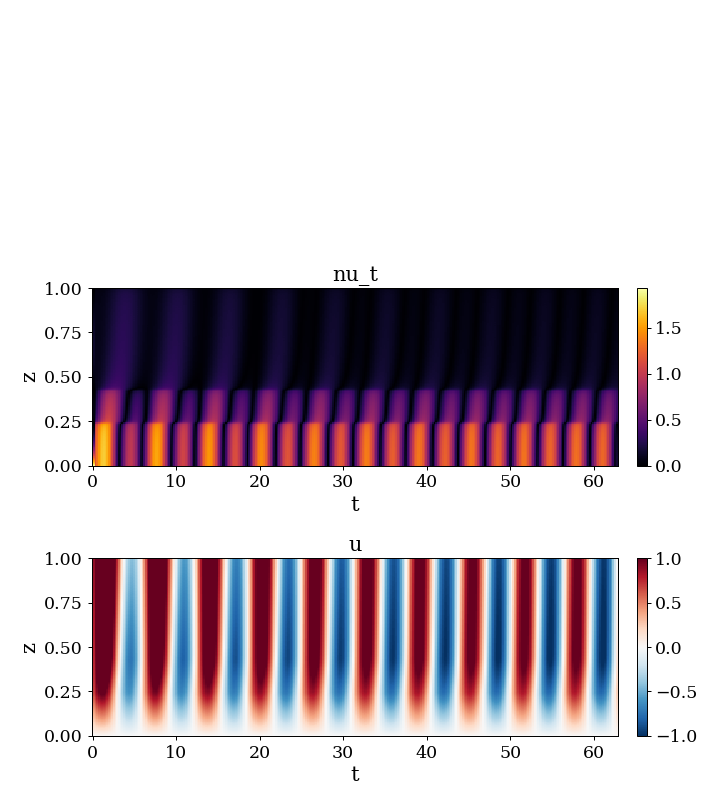

In [48]:
u_array = np.array(u_list)
nu_array = np.array(nu_list)
t_array = np.array(t_list)
zmesh, tmesh = quad_mesh(x=z, y=t_array)

plt.figure(figsize=(8, 9))
plt.subplot2grid((3, 20), (1, 0), colspan=19)
plt.pcolormesh(tmesh.T, zmesh.T, nu_array.T, cmap='inferno', vmin=0)
plt.ylabel('z')
plt.xlabel('t')
plt.title('nu_t')
cax = plt.subplot2grid((3, 20), (1, 19), colspan=1)
plt.colorbar(cax=cax)

plt.subplot2grid((3, 20), (2, 0), colspan=19)
plt.pcolormesh(tmesh.T, zmesh.T, u_array.T, cmap='RdBu_r', vmin = -1, vmax = 1)
plt.axis(pad_limits(tmesh, zmesh))
plt.ylabel('z')
plt.xlabel('t')
plt.title('u')
cax = plt.subplot2grid((3, 20), (2, 19), colspan=1)
plt.colorbar(cax=cax)

plt.tight_layout()
plt.show()

In [161]:
u_array.shape, z.shape, len(t_list)

((63, 200), (200,), 63)

<IPython.core.display.Javascript object>


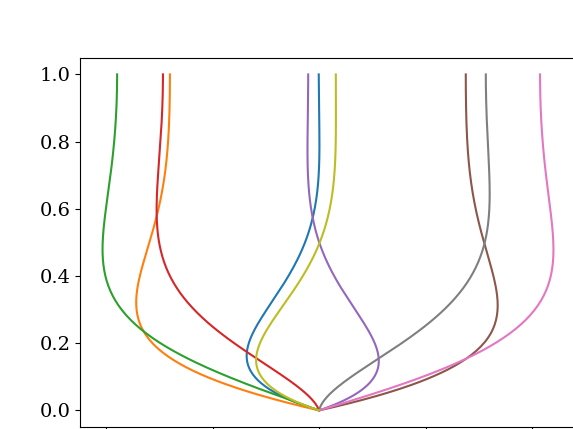

TypeError: float() argument must be a string or a number, not 'UnaryGridFunctionField'

In [346]:
def get_ind(t_array, val):
    
    dt = np.abs(t_array-val)
    return np.where(dt==np.min(dt))[0][0]

delta = np.sqrt(2*nu) # assumes zero freq

plt.figure()
# plt.plot(u_array[0,:], z, 'k:')
plt.plot(u_array[get_ind(t_array, 1.00*np.pi),:], z)
plt.plot(u_array[get_ind(t_array, 1.25*np.pi),:], z)
plt.plot(u_array[get_ind(t_array, 1.50*np.pi),:], z)
plt.plot(u_array[get_ind(t_array, 1.75*np.pi),:], z)
plt.plot(u_array[get_ind(t_array, 2.00*np.pi),:], z)
plt.plot(u_array[get_ind(t_array, 2.25*np.pi),:], z)
plt.plot(u_array[get_ind(t_array, 2.50*np.pi),:], z)
plt.plot(u_array[get_ind(t_array, 2.75*np.pi),:], z)
plt.plot(u_array[get_ind(t_array, 3.00*np.pi),:], z)
# plt.plot(u_array[-1,:],z, 'k')

plt.plot([-1, 1], [delta, delta], 'k--')
plt.grid()